<a href="https://colab.research.google.com/github/leejaehyeong1/AI/blob/main/03_CIFAR_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchsummary import summary
import torch.nn.utils.prune as prune

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin = (device.type == 'cuda')
print("device:", device)

device: cuda:0


# CIFAR-10 DataSet  
- 출처: Canadian Institute for Advanced Research

- 구성: 32×32 RGB 컬러 이미지 60,000장

- 학습용 50,000장 / 테스트용 10,000장

- 10개 클래스  
```
0: airplane    1: automobile
2: bird        3: cat
4: deer        5: dog
6: frog        7: horse
8: ship        9: truck

```

CIFAR-10 데이터셋 로드 중...


100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


CIFAR-10 데이터셋 로드 완료
훈련 데이터: 50000개
테스트 데이터: 10000개

CIFAR-10 샘플 이미지들:


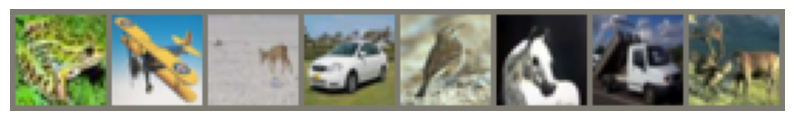

클래스:  frog plane  deer   car  bird horse truck  deer

이미지 크기: torch.Size([3, 32, 32])
배치 크기: 128
클래스 개수: 10


In [ ]:
# ===================================================================
# CIFAR-10 데이터셋 이해와 전처리
# ===================================================================
# 데이터 전처리 정의
transform_train = transforms.Compose([
  transforms.ToTensor(), # 이미지를 텐서로 변환
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) # 정규화: RGB 채널별 평균(mean)과 표준편차(std)
])
transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
# 데이터셋 불러오기
print("CIFAR-10 데이터셋 로드 중...")
try:
  train_dataset = torchvision.datasets.CIFAR10(
  root='./data', train=True, download=True, transform=transform_train)
  test_dataset = torchvision.datasets.CIFAR10(
  root='./data', train=False, download=True, transform=transform_test)
  # 데이터 로더 생성
  train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=128, shuffle=True, num_workers=0)
  test_loader = torch.utils.data.DataLoader(
                test_dataset, batch_size=100, shuffle=False, num_workers=0)
  print("CIFAR-10 데이터셋 로드 완료")
  print(f"훈련 데이터: {len(train_dataset)}개")
  print(f"테스트 데이터: {len(test_dataset)}개")
except Exception as e:
  print(f"데이터셋 로드 중 오류 발생: {e}")
  print("인터넷 연결을 확인하거나 데이터셋 경로를 확인해주세요.")

# 클래스 이름
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck')

# 이미지 시각화 함수
def imshow(img):
    # CIFAR-10 정규화 해제용 mean, std
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)

    # 정규화 해제
    img = img * std + mean
    npimg = img.numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# 샘플 이미지 시각화
try:
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    print("\nCIFAR-10 샘플 이미지들:")
    imshow(torchvision.utils.make_grid(images[:8]))
    print('클래스: ' + ' '.join('%5s' % classes[labels[j]] for j in
    range(8)))
    # CIFAR-10 데이터셋 정보 출력
    print(f"\n이미지 크기: {images[0].shape}")
    print(f"배치 크기: {images.shape[0]}")
    print(f"클래스 개수: {len(classes)}")
except Exception as e:
    print(f"이미지 시각화 중 오류 발생: {e}")

## 라벨 확인하기

In [ ]:
# 라벨 확인하기
print(train_dataset.targets[:20])   # 처음 20개 라벨 인덱스 출력
unique_labels = set(train_dataset.targets)
print("유니크 라벨 인덱스:", unique_labels)

for i in range(10):
    label_idx = train_dataset.targets[i]
    print(f"이미지 {i} → 라벨 인덱스: {label_idx}, 클래스명: {train_dataset.classes[label_idx]}")


[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]
유니크 라벨 인덱스: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
이미지 0 → 라벨 인덱스: 6, 클래스명: frog
이미지 1 → 라벨 인덱스: 9, 클래스명: truck
이미지 2 → 라벨 인덱스: 9, 클래스명: truck
이미지 3 → 라벨 인덱스: 4, 클래스명: deer
이미지 4 → 라벨 인덱스: 1, 클래스명: automobile
이미지 5 → 라벨 인덱스: 1, 클래스명: automobile
이미지 6 → 라벨 인덱스: 2, 클래스명: bird
이미지 7 → 라벨 인덱스: 7, 클래스명: horse
이미지 8 → 라벨 인덱스: 8, 클래스명: ship
이미지 9 → 라벨 인덱스: 3, 클래스명: cat


## 이미지 시각화
### 채널 순서 변환  
`np.transpose(img.numpy(), (1, 2, 0))`
| Framework                       | 형식        | 예시 크기       |
| ------------------------------- | --------- | ----------- |
| **PyTorch (Tensor)**            | (C, H, W) | (3, 32, 32) |
| **Matplotlib / NumPy (이미지 표준)** | (H, W, C) | (32, 32, 3) |   

- 변환 전:
img.shape = (3, 32, 32)
→ 3개의 채널, 각 채널은 32×32

- 변환 후:
npimg.shape = (32, 32, 3)
→ 높이 32, 너비 32, RGB 3채널

- 이제 Matplotlib이 올바르게 인식해서 색상 있는 이미지로 보여줄 수 있게 됩니다.


6 frog


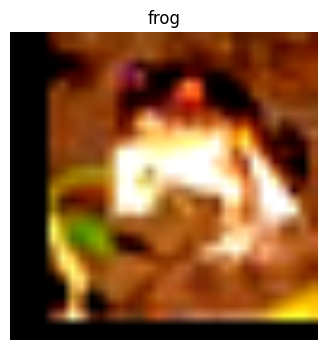

In [ ]:
img, label = train_dataset[0]
print(label, train_dataset.classes[label])

import matplotlib.pyplot as plt
import numpy as np

# 정규화 해제
img = img / 2 + 0.5
npimg = np.transpose(img.numpy(), (1, 2, 0))

plt.figure(figsize=(4,4))
plt.imshow(npimg, interpolation='bilinear')  # ← bilinear로 부드럽게 확대
plt.title(train_dataset.classes[label])
plt.axis('off')
plt.show()


# 모델 구현 - 합성곱 신경망  

## 설명  
## 1️⃣ 입력 데이터

* **CIFAR-10**은 `3채널 RGB` 이미지이며, 각 이미지의 크기는 `32×32` 픽셀입니다.
* 따라서 입력 텐서의 형태는 다음과 같습니다:

  ```
  (N, 3, 32, 32)
  ```

  여기서 `N`은 **배치 크기(batch size)** 를 의미합니다.



## 2️⃣ 특성 추출부 (`self.features`)

이 부분은 **이미지로부터 유용한 시각적 특징(feature)** 을 추출하는 합성곱 계층들로 구성됩니다.
각 블록은 아래의 연산 순서를 따릅니다:

```
Conv → BatchNorm → ReLU → Conv → BatchNorm → ReLU → MaxPool → Dropout
```

### 🔹 구성 요약

| 블록      | 입력 채널 | 출력 채널 | 출력 크기(H×W) | 주요 역할                |
| ------- | ----- | ----- | ---------- | -------------------- |
| Block 1 | 3     | 32    | 32 → 16    | 엣지·색상 등 저수준 특징 추출    |
| Block 2 | 32    | 64    | 16 → 8     | 사물의 부분적 형태 추출        |
| Block 3 | 64    | 128   | 8 → 4      | 전체 구조·패턴 등 고수준 특징 추출 |

> **채널 수 변화:** 3 → 32 → 64 → 128   
> **공간 크기 변화:** 32×32 → 16×16 → 8×8 → 4×4  

즉, **CNN의 합성곱 계층은 공간 정보를 점차 압축하며,
의미적(semantic) 정보는 점점 풍부하게 만듭니다.**


## 3️⃣ 분류부 (`self.classifier`)

특징 맵을 1차원 벡터로 평탄화한 후, 완전연결층을 통해 **10개 클래스**로 분류합니다.

```
Flatten → Linear(2048→512) → ReLU → Dropout(0.5) → Linear(512→10)
```

| 단계             | 역할                                           | 설명 |
| -------------- | -------------------------------------------- | -- |
| Flatten        | 3D feature map을 1D 벡터로 변환 (128×4×4 = 2048차원) |    |
| Linear + ReLU  | 비선형 결합을 통해 고차원 표현 학습                         |    |
| Dropout        | 과적합 방지                                       |    |
| Linear(512→10) | 10개 클래스에 대한 로짓(logit) 출력                     |    |



## 4️⃣ 전체 흐름 요약

```
입력 (3×32×32)
   ↓
[특징 추출부]
  Conv + BN + ReLU × 2
  ↓
  MaxPool + Dropout
  ↓
  (3단 반복: 3→32→64→128 채널)
   ↓
[분류기]
  Flatten → FC(512) → Dropout → FC(10)
   ↓
출력 (10개 클래스)
```


## 5️⃣ 요약 비교

| 구성             | 역할          | 핵심 특징                 |
| -------------- | ----------- | --------------------- |
| **Block 1**    | 저수준 특징 추출   | 엣지, 색상, 질감     |       |
| **Block 2**    | 중간 수준 특징 추출 | 물체의 부분 형태             |
| **Block 3**    | 고수준 특징 추출   | 물체의 전체 구조             |
| **Classifier** | 최종 분류 단계    | Flatten → FC → 10 클래스 |



✅ **정리:**  
이 CNN 모델은 입력 이미지를 점진적으로 압축하며 특징을 계층적으로 추출한 뒤,
완전연결층을 통해 10개 클래스를 예측하는 **소형 VGG 스타일의 합성곱 신경망**입니다.


In [ ]:
# ===================================================================
# 합성곱 신경망 모델 구현 및 학습
# ===================================================================
# CIFAR-10용 CNN 모델 정의
# 이미지 → CNN으로 특징 추출 → FC로 클래스 확률 예측
class CIFAR10_CNN(nn.Module):
  def __init__(self):
    super(CIFAR10_CNN, self).__init__()
    # 특성 추출 레이어
    self.features = nn.Sequential(
      # 첫 번째 합성곱 블록
      nn.Conv2d(3, 32, kernel_size=3, padding=1),  nn.BatchNorm2d(32),    nn.ReLU(inplace=True),
      nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32),    nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(0.25),
      # 두 번째 합성곱 블록
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(0.25),
      # 세 번째 합성곱 블록
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(0.25),
    )

    # 분류 레이어
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 4 * 4, 512), # 2048 -> 512로 압축
      nn.ReLU(inplace=True),
      nn.Dropout(0.5),
      nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.features(x)    # CNN 블록을 통과해 특성맵 추출
    x = self.classifier(x)  # 완전연결층을 통해 분류
    return x

# 모델, 손실 함수, 최적화 초기화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cifar_model = CIFAR10_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_model.parameters(), lr=0.001)
print("CIFAR-10 CNN 모델:")
print(cifar_model)

# 모델 파라미터 수
cifar_params = sum(p.numel() for p in cifar_model.parameters())
print(f"\nCIFAR-10 CNN 파라미터 수: {cifar_params:,}")
print(f"사용 디바이스: {device}")

CIFAR-10 CNN 모델:
CIFAR10_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, pa

# 학습 함수   
| 개념                      | 설명                            |
| ----------------------- | ----------------------------- |
| `model.train()`         | 학습 모드 (Dropout, BatchNorm 활성) |
| `optimizer.zero_grad()` | Gradient 누적 방지                |
| `loss.backward()`       | 오차 역전파로 gradient 계산           |
| `optimizer.step()`      | 계산된 gradient로 파라미터 갱신         |
| `predicted.eq(labels)`  | 예측과 실제 비교로 정확도 계산             |


In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()                      # ① 모델을 학습 모드로 전환 (Dropout, BN 활성화)
    running_loss, correct, total = 0, 0, 0

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= 10:                    # ② 데모용: 10배치까지만 실행
            break
        inputs, labels = inputs.to(device), labels.to(device)   # ③ GPU/CPU 이동

        optimizer.zero_grad()          # ④ 이전 step의 gradient 초기화
        outputs = model(inputs)        # ⑤ 순전파 (Forward propagation)
        loss = criterion(outputs, labels)  # ⑥ 손실 계산
        loss.backward()                # ⑦ 역전파 (Backward propagation)
        optimizer.step()               # ⑧ 가중치 갱신

        running_loss += loss.item()    # ⑨ 손실 누적
        _, predicted = outputs.max(1)  # ⑩ 예측 결과 (argmax)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()  # ⑪ 정답 비교 → 정확도 계산

        if i % 5 == 4:                 # ⑫ 중간 결과 출력 (5배치마다)
            print(f'배치 {i+1}, 손실: {running_loss/(i+1):.3f}, 정확도:{100.*correct/total:.2f}%')

    # ⑬ epoch 평균 손실, 정확도 반환
    return running_loss / min(i+1, 10), 100. * correct / total


In [ ]:
# 정답 비교 코드 동작 원리
import torch

predicted = torch.tensor([1, 0, 4, 9])
labels    = torch.tensor([1, 2, 4, 9])

print(predicted.eq(labels))

# → tensor([True, False, True, True])

predicted.eq(labels).sum().item()

tensor([ True, False,  True,  True])


3

# 평가 함수  
| 개념                | 설명                      |
| ----------------- | ----------------------- |
| `model.eval()`    | 평가 모드 (Dropout, BN 비활성) |
| `torch.no_grad()` | gradient 계산 방지 → 메모리 절약 |
| `outputs.max(1)`  | 클래스 예측 결과 계산            |
| `correct / total` | 전체 정확도 산출               |


In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()                       # ① 평가 모드 (Dropout, BN 고정)
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():              # ② 평가 시 gradient 계산 비활성화
        for i, (inputs, labels) in enumerate(test_loader):
            if i >= 5:                 # ③ 데모용: 5배치까지만 평가
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()   # ④ 손실 누적
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # ⑤ 평균 손실 및 정확도 반환
    return test_loss / (i+1), 100. * correct / total

# 학습 실행

In [ ]:
# 간단한 학습 실행 (데모용)
try:
  if 'train_loader' in locals():
    print("\n=== 모델 학습 시작 (데모) ===")
    for epoch in range(2): # 2 에포크만 실행
      print(f"\n에포크 {epoch+1}:")
      train_loss, train_acc = train_epoch(cifar_model, train_loader, criterion, optimizer, device)

    print("\n=== 모델 평가 ===")
    test_loss, test_acc = evaluate_model(cifar_model, test_loader, criterion, device)
    print(f"테스트 손실: {test_loss:.3f}, 테스트 정확도: {test_acc:.2f}%")
  else:
    print("데이터 로더가 준비되지 않아 학습을 건너뜁니다.")
except Exception as e:
    print(f"학습 중 오류 발생: {e}")


=== 모델 학습 시작 (데모) ===

에포크 1:
배치 5, 손실: 1.552, 정확도: 44.53%
배치 10, 손실: 1.560, 정확도: 44.69%

에포크 2:
배치 5, 손실: 1.549, 정확도: 43.28%
배치 10, 손실: 1.537, 정확도: 44.77%

=== 모델 평가 ===
학습 중 오류 발생: 'NoneType' object is not iterable


# 데이터 증강  
데이터 증강은 학습 데이터의 다양성을 인위적으로 늘려 모델의 일반화 성능을 향상시키는 기법이다. CIFAR-10과 같은 작은 이미지 데이터셋에서 특히 중요하다.

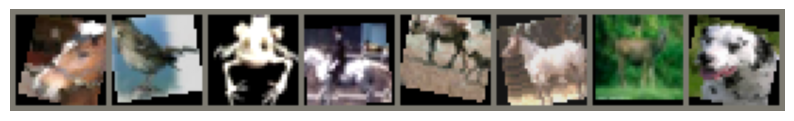

horse  bird  frog horse  deer horse  deer   dog


In [ ]:
# ===================================================================
# 데이터 증강(Data Augmentation) 기법 적용
# ===================================================================
# CIFAR-10 클래스 이름
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

# 더 다양한 데이터 증강 기법 적용
transform_train_augmented = transforms.Compose([
  transforms.RandomCrop(32, padding=4), # 랜덤 크롭
  transforms.RandomHorizontalFlip(), # 수평 뒤집기
  transforms.RandomRotation(15), # 랜덤 회전 (±15도)
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
  # 색상 변화
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# 증강된 데이터셋 불러오기
train_dataset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_augmented)
train_loader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=128, shuffle=True, num_workers=2)

# 증강된 샘플 이미지 시각화
dataiter = iter(train_loader_augmented) # DataLoader에서 배치(batch)를 하나씩 꺼냄
images, labels = next(dataiter)         # 다음 배치 꺼내기
imshow(torchvision.utils.make_grid(images[:8])) # 여러 이미지를 한 장의 격자(grid)로 합쳐주는 함수
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [ ]:
# ===================================================================
# 모델 학습 및 평가 함수
# ===================================================================
# 디바이스 설정(중요!)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()                      # ① 모델을 학습 모드로 전환 (Dropout, BN 활성화)
    running_loss, correct, total = 0, 0, 0

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= 10:                    # ② 데모용: 10배치까지만 실행
            break
        inputs, labels = inputs.to(device), labels.to(device)   # ③ GPU/CPU 이동

        optimizer.zero_grad()          # ④ 이전 step의 gradient 초기화
        outputs = model(inputs)        # ⑤ 순전파 (Forward propagation)
        loss = criterion(outputs, labels)  # ⑥ 손실 계산
        loss.backward()                # ⑦ 역전파 (Backward propagation)
        optimizer.step()               # ⑧ 가중치 갱신

        running_loss += loss.item()    # ⑨ 손실 누적
        _, predicted = outputs.max(1)  # ⑩ 예측 결과 (argmax)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()  # ⑪ 정답 비교 → 정확도 계산

        if i % 5 == 4:                 # ⑫ 중간 결과 출력 (5배치마다)
            print(f'배치 {i+1}, 손실: {running_loss/(i+1):.3f}, 정확도:{100.*correct/total:.2f}%')

    # ⑬ epoch 평균 손실, 정확도 반환
    return running_loss / min(i+1, 10), 100. * correct / total

def evaluate_model(model, test_loader, criterion, device):
    model.eval()                       # ① 평가 모드 (Dropout, BN 고정)
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():              # ② 평가 시 gradient 계산 비활성화
        for i, (inputs, labels) in enumerate(test_loader):
            if i >= 5:                 # ③ 데모용: 5배치까지만 평가
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()   # ④ 손실 누적
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # ⑤ 평균 손실 및 정확도 반환
    return test_loss / (i+1), 100. * correct / total


# 안전한 학습 함수(에러 처리 포함)
def safe_train_model(model, train_loader, test_loader, criterion, optimizer,
                     device, epochs=2):

  try:
    print(f"모델 디바이스: {next(model.parameters()).device}")
    print(f"타겟 디바이스: {device}")
    model = model.to(device)

    for epoch in range(epochs):
      print(f"\n에포크 {epoch+1}/{epochs}:")
      # 학습
      train_loss, train_acc = train_epoch(model, train_loader,criterion, optimizer, device)
      print(f"학습 완료 - 손실: {train_loss:.3f}, 정확도: {train_acc:.2f}%")

      # 평가
      if test_loader is not None:
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        print(f"평가 완료 - 손실: {test_loss:.3f}, 정확도: {test_acc:.2f}%")
    print("\n학습 완료!")

  except Exception as e:
    print(f"학습 중 오류 발생: {e}")
    print("오류 해결 방법:")
    print("1. 모델과 데이터가 같은 디바이스에 있는지 확인")
    print("2. 메모리 부족시 배치 크기 줄이기")
    print("3. CUDA 사용 가능한지 확인")

# ===================================================================
# 실제 학습 실행
# ===================================================================
print("\n=== 안전한 모델 학습 시작 ===")

try:
  # 사용할 모델 선택 또는 생성
  if 'cifar_model' in locals():
    model = cifar_model
    print("CIFAR-10 CNN 모델 사용")
  elif 'simple_cnn' in locals():
    model = simple_cnn
    print("Simple CNN 모델 사용")
  else:
    # 간단한 모델 직접 정의
    class SimpleCNN(nn.Module):
      def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(32, 64, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(64, 128, 3, padding=1),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(128, 10)
        )
      def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    model = SimpleCNN()
    print("새로운 Simple CNN 모델 생성")

  # 모델을 디바이스로 이동
  model = model.to(device)

  # 손실 함수 및 옵티마이저 설정
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # 데이터 로더 확인(locals와 globals 모두 확인)
  train_loader, test_loader = None, None
  all_vars = {**globals(), **locals()}
  possible_train_loaders = ['train_loader_augmented', 'train_loader']
  possible_test_loaders = ['test_loader']

  # train_loader 찾기
  for loader_name in possible_train_loaders:
    if loader_name in all_vars:
      train_loader = all_vars[loader_name]
      print(f"✔ {loader_name} 발견하여 사용")
      break

  # test_loader 찾기
  for loader_name in possible_test_loaders:
    if loader_name in all_vars:
      test_loader = all_vars[loader_name]
      print(f"✔ {loader_name} 발견하여 사용")
      break

  # 데이터 로더가 없으면 직접 생성
  if train_loader is None:

    print("❌ 기존 데이터 로더 없음 → CIFAR-10 새로 생성")
    try:
      import torchvision
      import torchvision.transforms as transforms

      # 기본 transform 정의
      transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
      ])
      transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
      ])
      train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
      test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
      train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
      test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
      print(f"✅ CIFAR-10 데이터 로더 생성 완료 ({len(train_dataset)} / {len(test_dataset)})")


    except Exception as e:
      print(f"❌ 데이터 로더 생성 실패: {e}")
      print("🔧 더미 데이터로 순전파 테스트만 실행합니다.")
      # 더미 데이터로 테스트
      dummy_data = torch.randn(4, 3, 32, 32).to(device)
      dummy_labels = torch.randint(0, 10, (4,)).to(device)
      print("더미 데이터로 순전파 테스트:")
      model.eval()
      with torch.no_grad():
        outputs = model(dummy_data)
      print(f"출력 크기: {outputs.shape}")
      print("순전파 테스트 성공!")
      train_loader = None # 학습 방지

  # 안전한 학습 실행(데이터 로더가 있는 경우만)
  if train_loader is not None:
    safe_train_model(model, train_loader, test_loader, criterion,
                     optimizer, device, epochs=2)
  else:
    print("학습용 데이터 로더가 없어서 학습을 건너뜁니다.")

except Exception as e:
  print(f"모델 설정 중 오류: {e}")
  print("\n디버깅 정보:")
  print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
  if torch.cuda.is_available():
    print(f"CUDA 디바이스 수: {torch.cuda.device_count()}")
    print(f"현재 CUDA 디바이스: {torch.cuda.current_device()}")

사용 디바이스: cuda:0

=== 안전한 모델 학습 시작 ===
CIFAR-10 CNN 모델 사용
✔ train_loader_augmented 발견하여 사용
✔ test_loader 발견하여 사용
모델 디바이스: cuda:0
타겟 디바이스: cuda:0

에포크 1/2:
배치 5, 손실: 1.539, 정확도:40.00%
배치 10, 손실: 1.552, 정확도:40.70%
학습 완료 - 손실: 1.552, 정확도: 40.70%

에포크 2/2:
배치 5, 손실: 1.567, 정확도:43.12%
배치 10, 손실: 1.572, 정확도:43.44%
학습 완료 - 손실: 1.572, 정확도: 43.44%

학습 완료!


# CNN의 시각화

Conv layers: ['features.0', 'features.3', 'features.8', 'features.11', 'features.16', 'features.19']


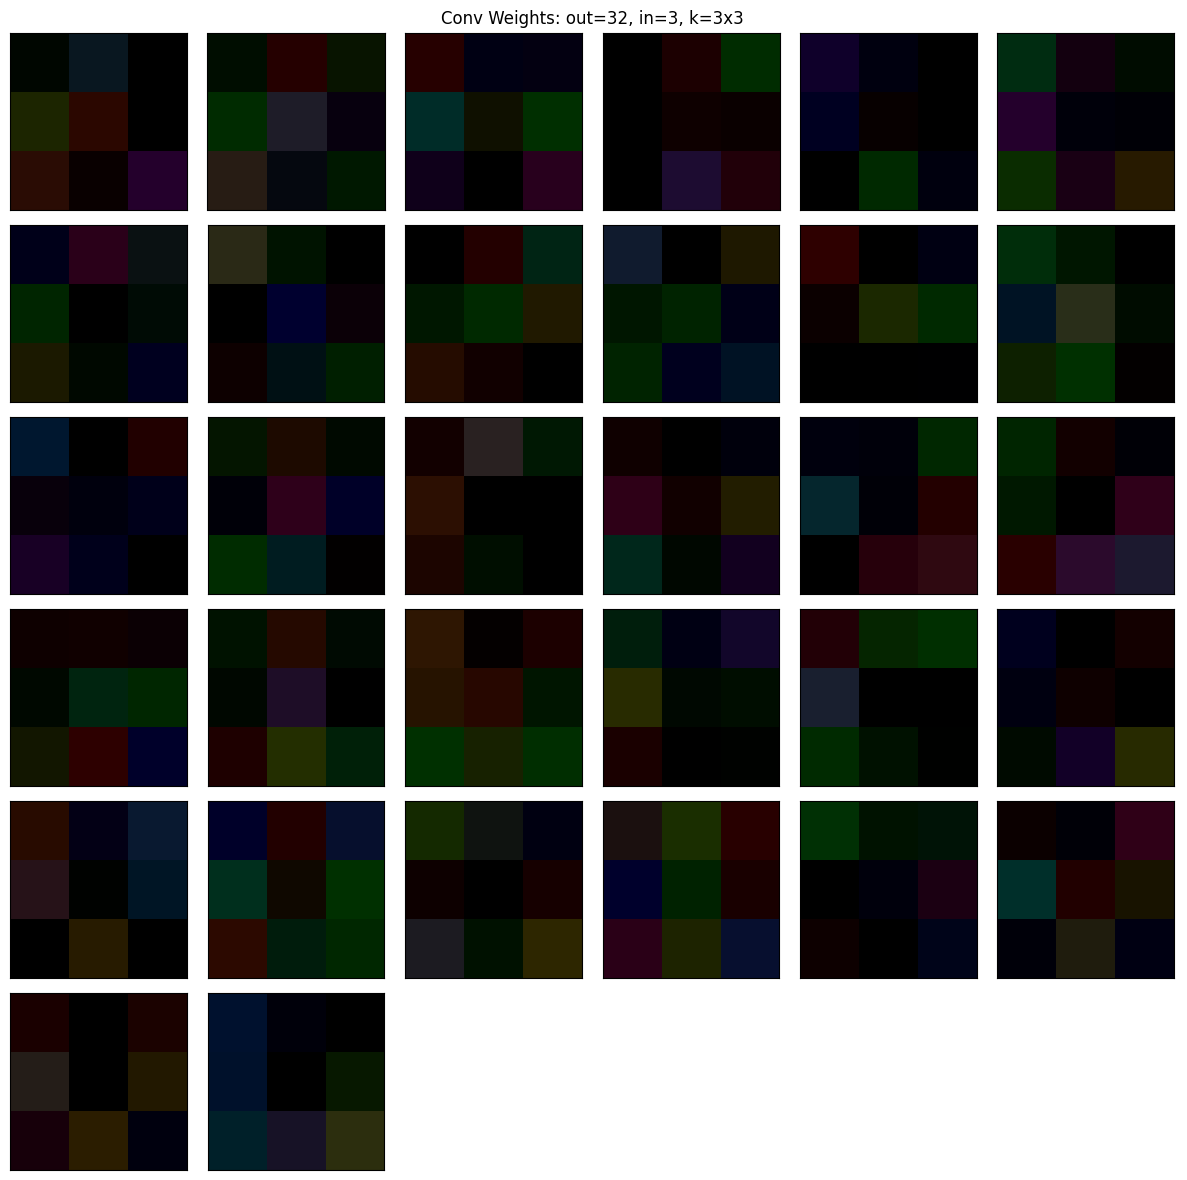

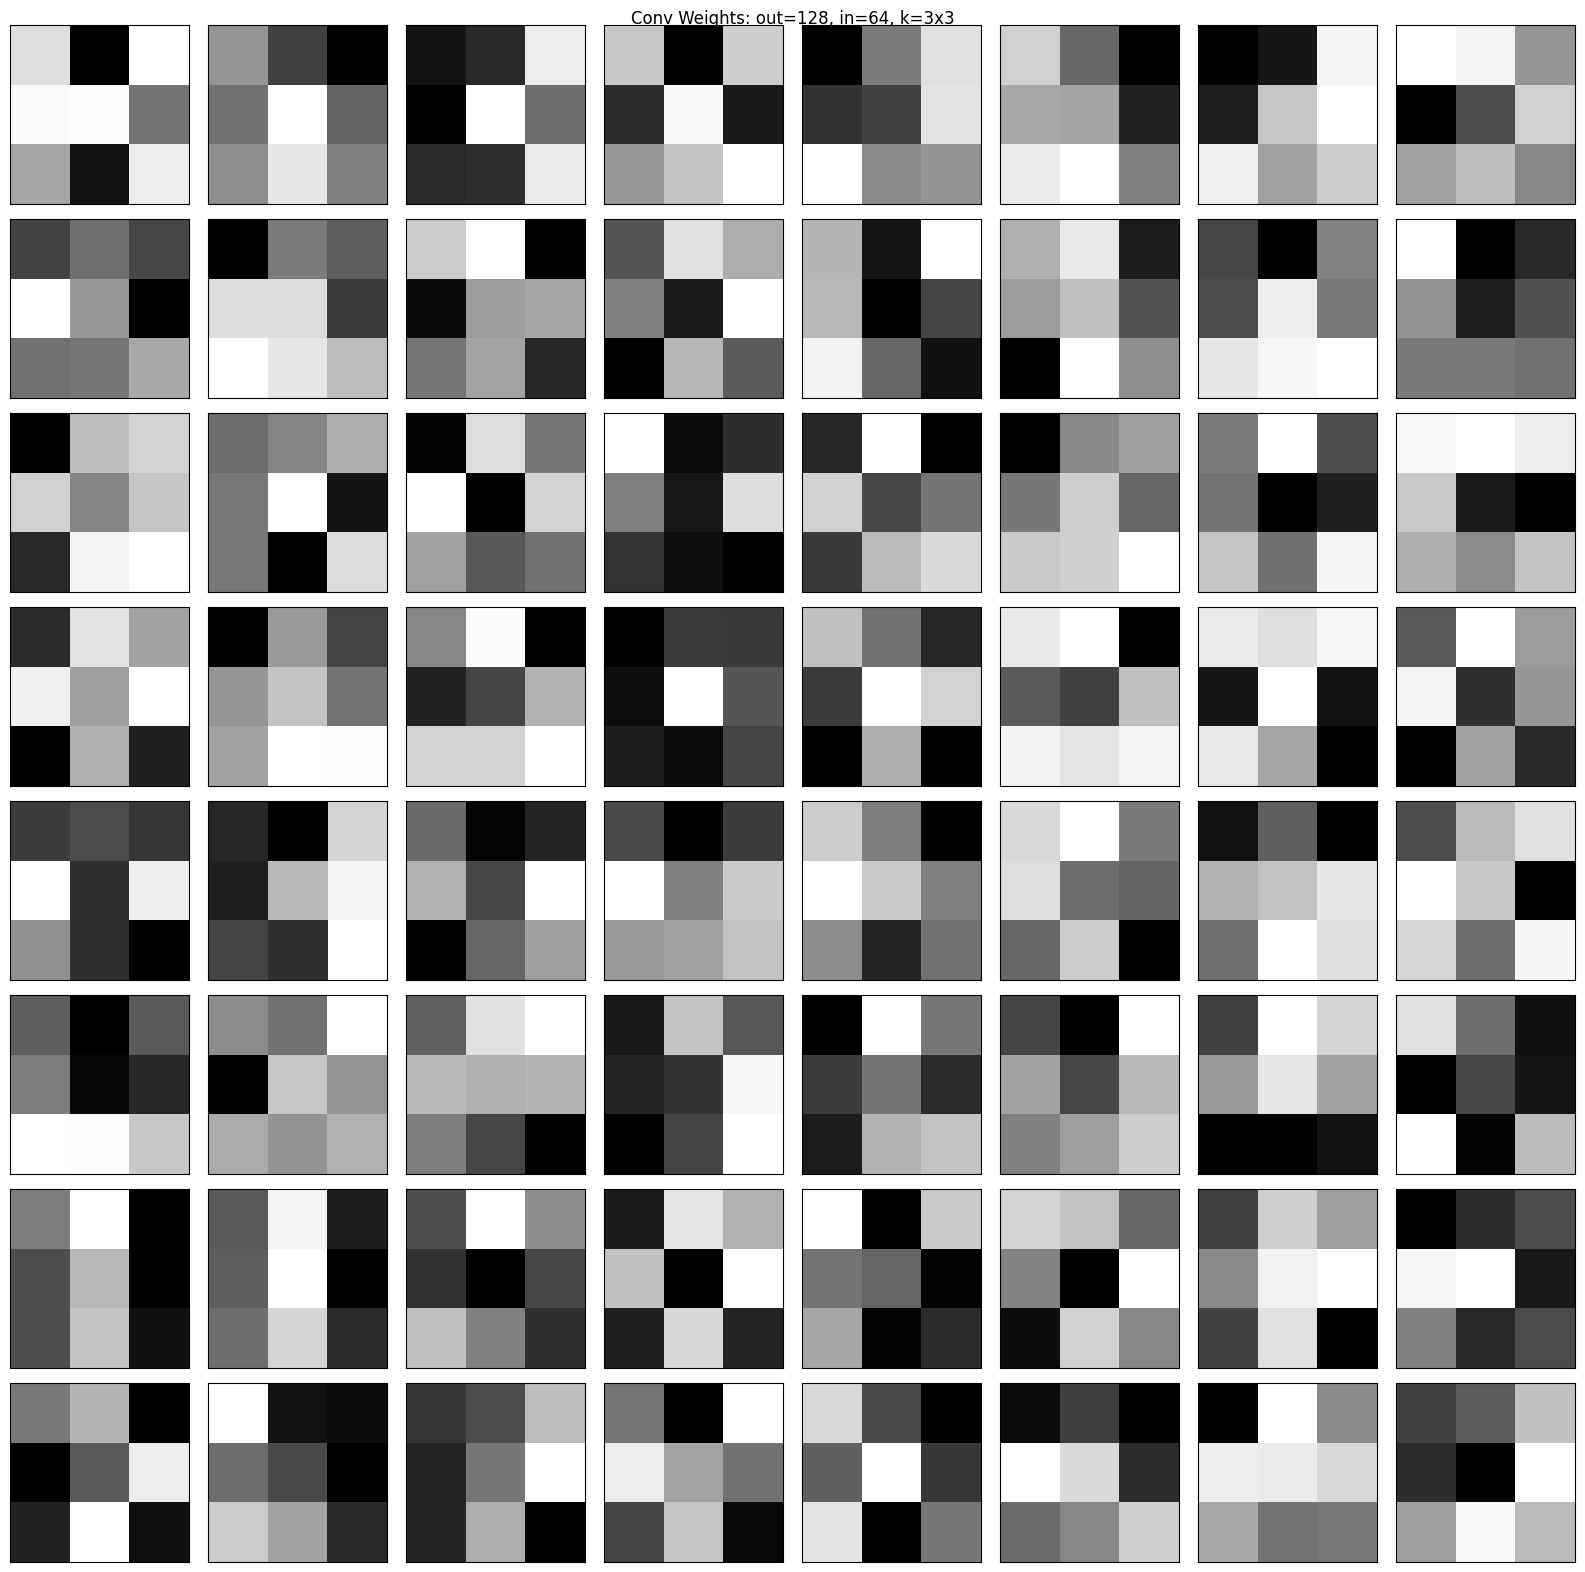

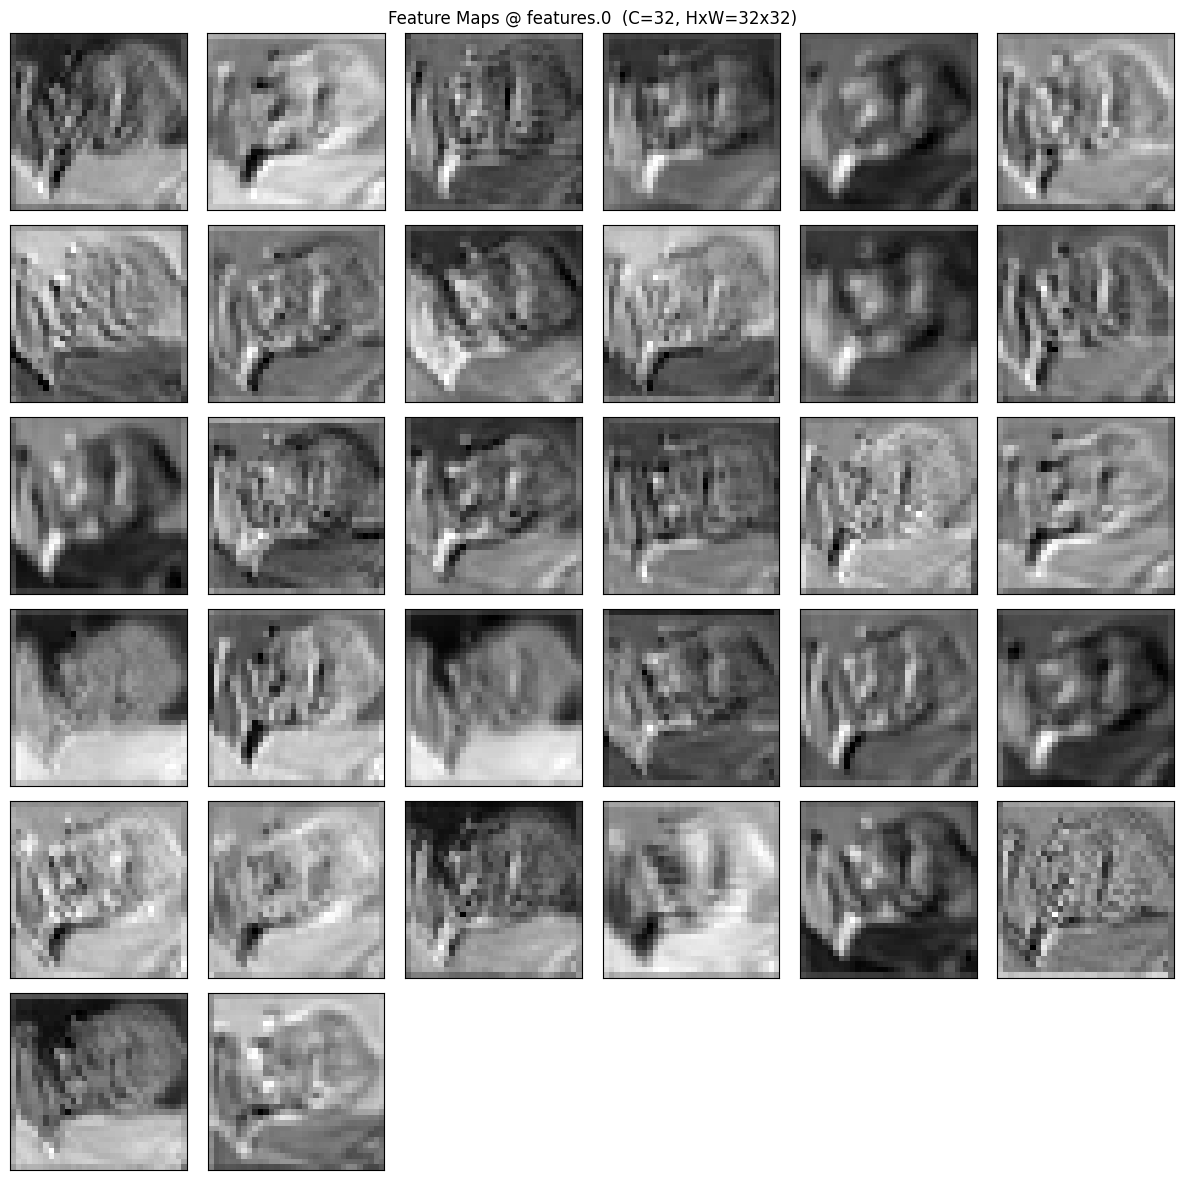

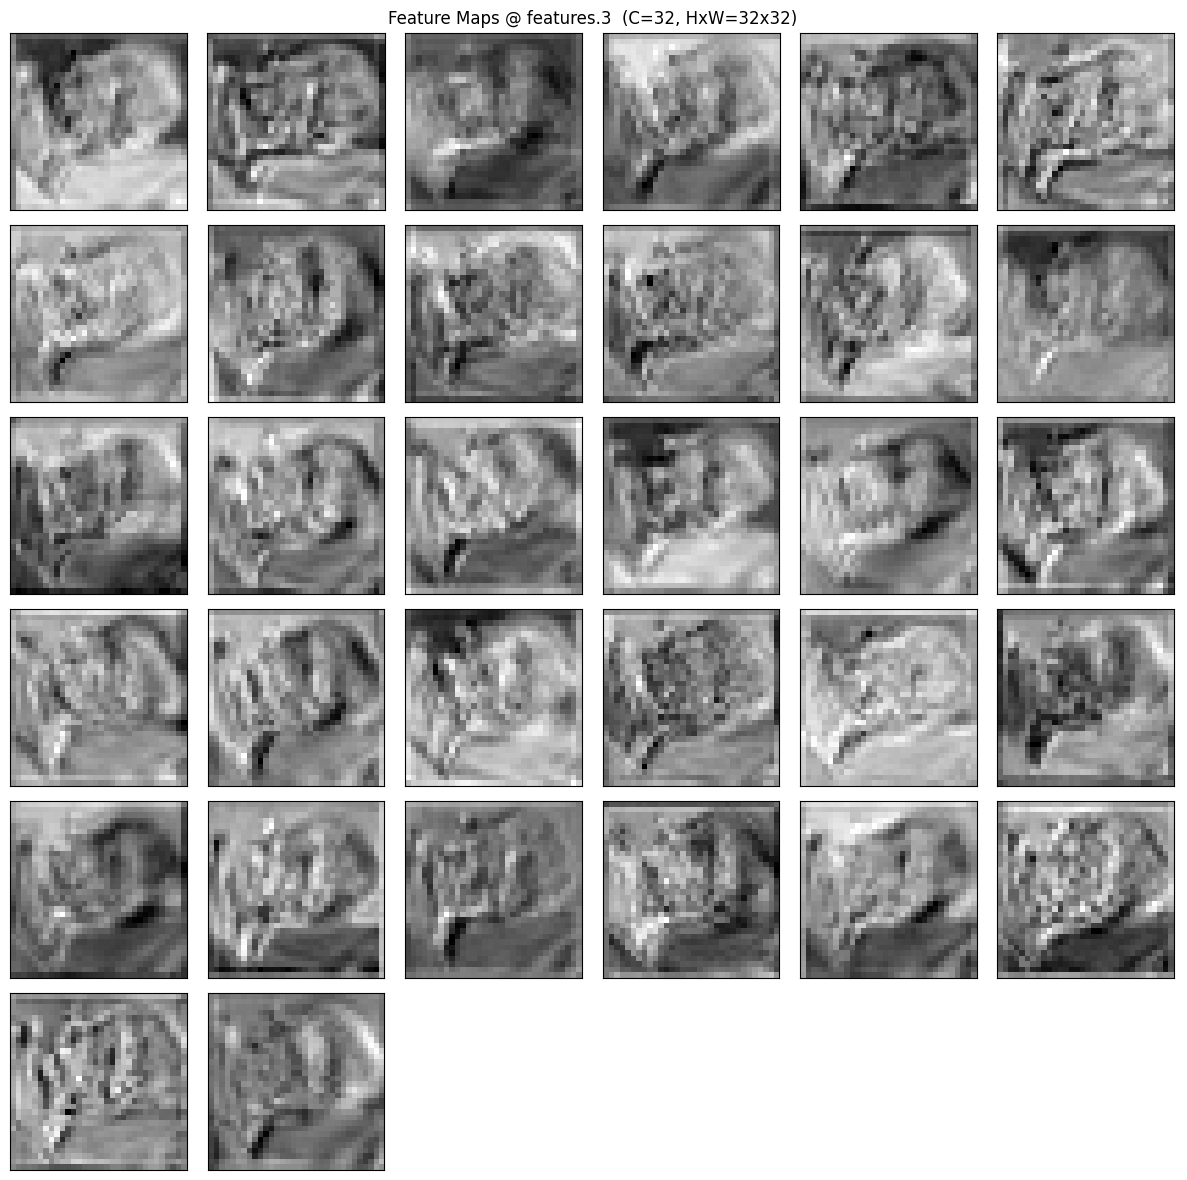

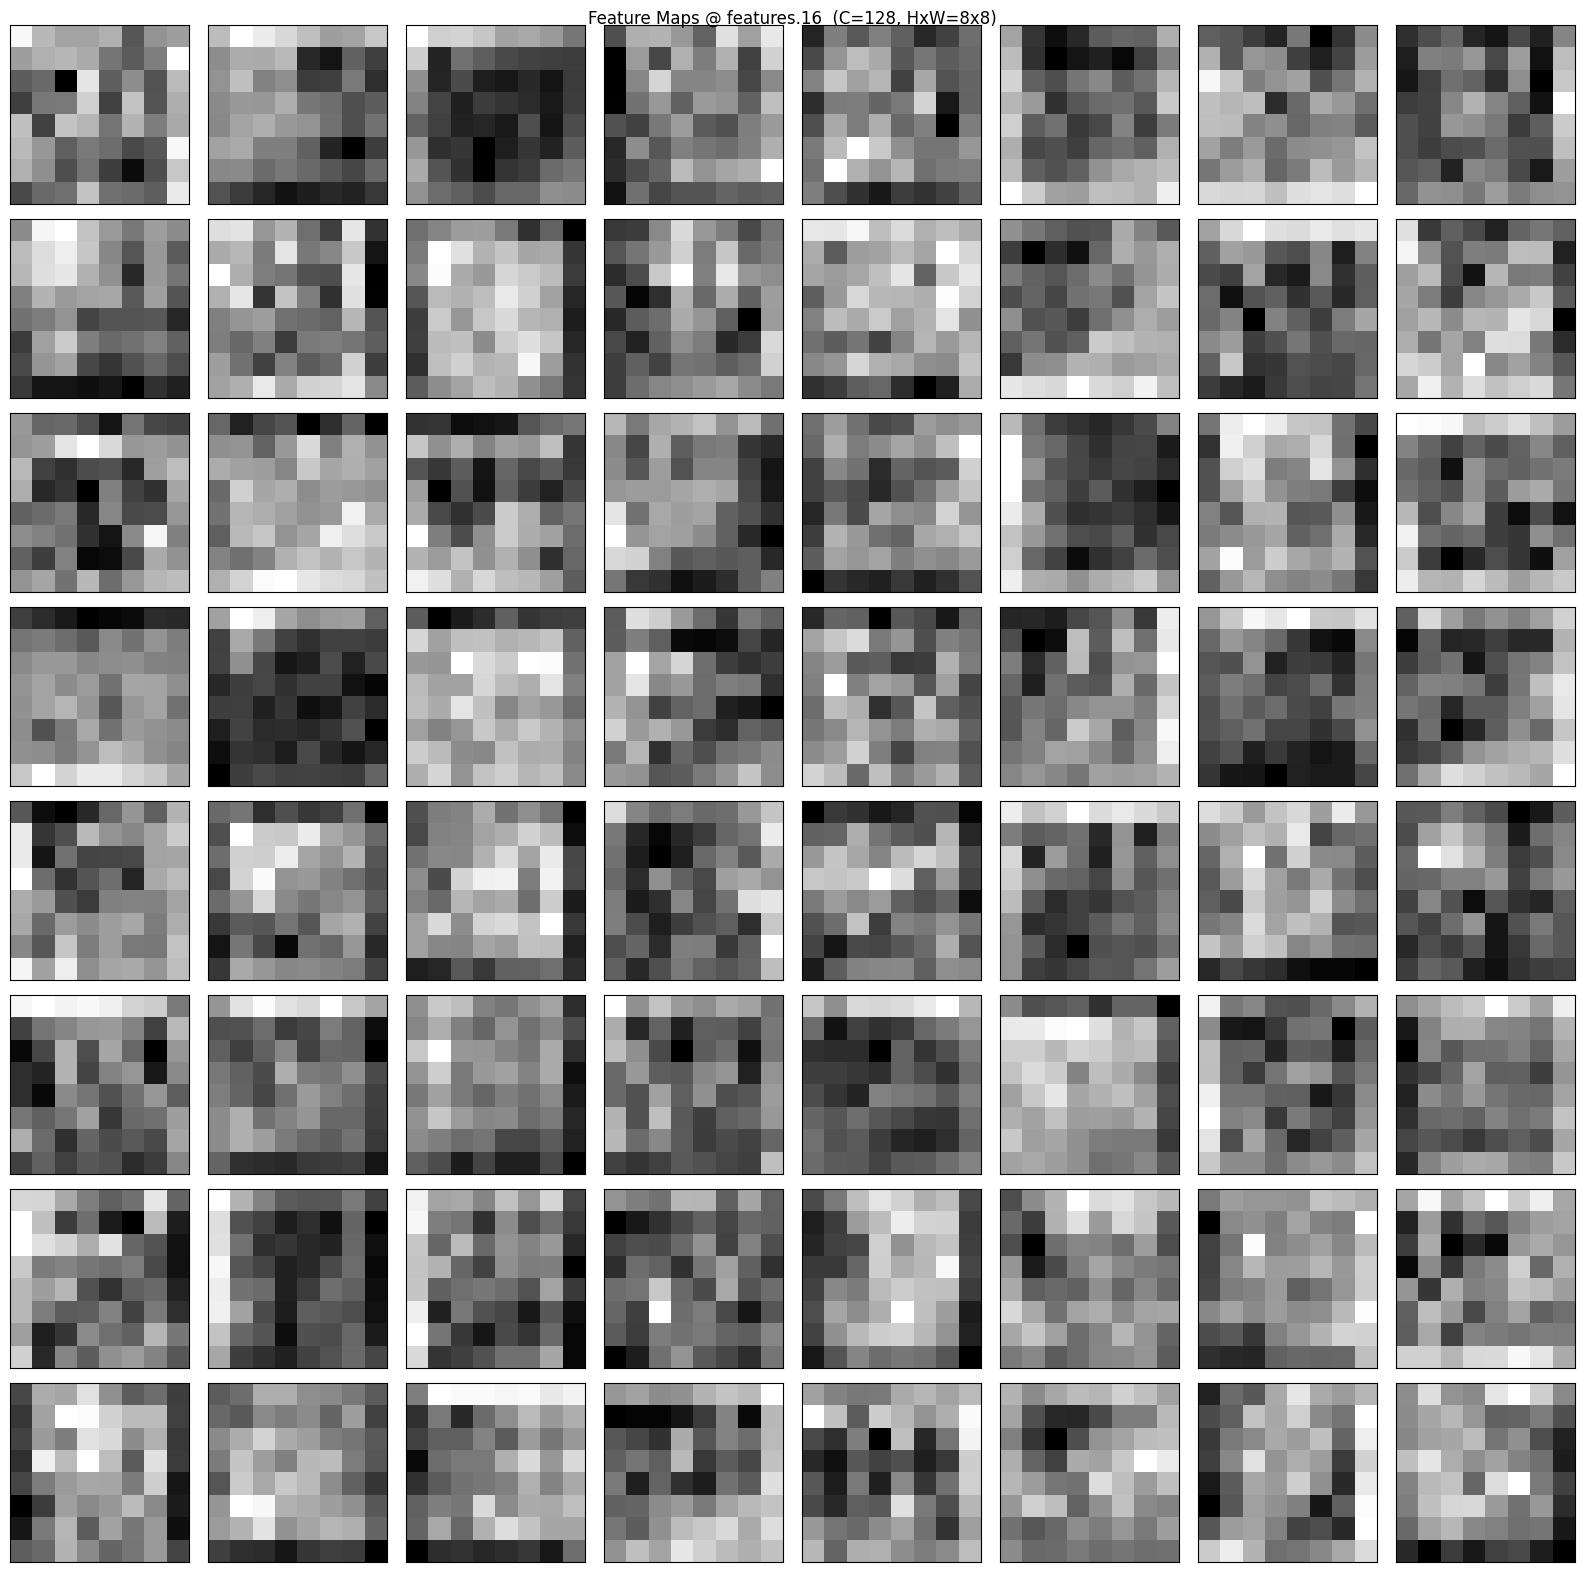

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def find_conv_layers(model: nn.Module):
    """
    모델 내 Conv2d 모듈을 (이름, 모듈) 튜플 리스트로 반환.
    예: [('features.0', Conv2d(...)), ('features.3', Conv2d(...)), ...]
    """
    convs = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            convs.append((name, module))
    return convs

def plot_conv_weights(conv: nn.Conv2d, per_filter_norm: bool = True, max_filters: int = 64):
    """
    Conv2d 가중치(필터)를 그리드로 표시.
    conv.weight: (out_channels, in_channels, kH, kW)
    - in_channels==3 이면 RGB로 합성해 표시
    - 그 외는 첫 채널(또는 평균)로 단일 채널 표시
    """
    with torch.no_grad():
        w = conv.weight.detach().cpu().numpy()  # (out_c, in_c, kH, kW)

    out_c, in_c, kH, kW = w.shape
    n = min(out_c, max_filters)
    grid = int(math.ceil(math.sqrt(n)))
    fig, axes = plt.subplots(grid, grid, figsize=(grid*2, grid*2))
    axes = np.array(axes).reshape(-1)

    # 전체 범위 vs 필터별 정규화 선택
    if per_filter_norm:
        w_min = w_max = None
    else:
        w_min, w_max = w.min(), w.max()

    for i in range(grid*grid):
        ax = axes[i]
        ax.set_xticks([]); ax.set_yticks([])
        if i < n:
            filt = w[i]  # (in_c, kH, kW)
            if in_c == 3:
                # RGB 합성
                img = np.transpose(filt, (1, 2, 0))  # (kH, kW, 3)
                if per_filter_norm:
                    vmin, vmax = img.min(), img.max()
                    ax.imshow(img, vmin=vmin, vmax=vmax)
                else:
                    ax.imshow(img, vmin=w_min, vmax=w_max)
            else:
                # 단일 채널 (필요시 filt.mean(0)로 교체 가능)
                img = filt[0]
                if per_filter_norm:
                    vmin, vmax = img.min(), img.max()
                    ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
                else:
                    ax.imshow(img, cmap='gray', vmin=w_min, vmax=w_max)
        else:
            ax.axis('off')

    fig.suptitle(f"Conv Weights: out={out_c}, in={in_c}, k={kH}x{kW}")
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def plot_feature_maps(model: nn.Module, x: torch.Tensor, target_layer_name: str,
                      max_maps: int = 64, device: torch.device = None):
    """
    특정 레이어의 출력 특성맵을 그리드로 표시.
    - model: 전체 모델 (여기서는 cifar_model)
    - x: (B, C, H, W) 하나만 넣는 걸 권장 (예: x[:1])
    - target_layer_name: 'features.0', 'features.3', 'features.8', 'features.11', 'features.16', 'features.19' 등
    """
    was_training = model.training
    model.eval()

    feats = {}
    def hook_fn(m, inp, out):
        feats['fm'] = out.detach().cpu()  # (B, C, H, W)

    target_module = dict(model.named_modules()).get(target_layer_name, None)
    if target_module is None:
        raise ValueError(f"레이어 '{target_layer_name}'를 찾을 수 없습니다. named_modules()를 확인하세요.")

    handle = target_module.register_forward_hook(hook_fn)

    if device is not None:
        model = model.to(device)
        x = x.to(device)

    _ = model(x)  # forward → hook에 의해 feats 채워짐
    handle.remove()

    fm = feats['fm']  # (B, C, H, W)
    B, C, H, W = fm.shape
    if B < 1:
        raise ValueError("배치 크기는 최소 1이어야 합니다.")

    n = min(C, max_maps)
    grid = int(math.ceil(math.sqrt(n)))
    fig, axes = plt.subplots(grid, grid, figsize=(grid*2, grid*2))
    axes = np.array(axes).reshape(-1)

    f0 = fm[0]  # (C, H, W)
    for i in range(grid*grid):
        ax = axes[i]
        ax.set_xticks([]); ax.set_yticks([])
        if i < n:
            ax.imshow(f0[i].numpy(), cmap='binary')
        else:
            ax.axis('off')

    fig.suptitle(f"Feature Maps @ {target_layer_name}  (C={C}, HxW={H}x{W})")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------
# 사용 예시
# ---------------------------------------------
# 1) Conv 레이어 이름/순서 확인
convs = find_conv_layers(cifar_model)
print("Conv layers:", [name for name, _ in convs])
# 기대되는 Conv 인덱스 (features 내부):
#  - Block1:  'features.0',  'features.3'
#  - Block2:  'features.8',  'features.11'
#  - Block3:  'features.16', 'features.19'

# 2) 가중치(필터) 시각화 예시
#    첫 번째 합성곱과 세 번째 블록 첫 합성곱을 그려봄
plot_conv_weights(dict(cifar_model.named_modules())['features.0']) # 첫 번째 블록
plot_conv_weights(dict(cifar_model.named_modules())['features.16']) # 세 번째 블록

# 3) 특성맵 시각화 예시 (테스트 배치가 있다면)
try:
    images, labels = next(iter(test_loader))
    x_one = images[:1]  # (1,3,32,32)
    plot_feature_maps(cifar_model, x_one, target_layer_name='features.0', device=device)
    plot_feature_maps(cifar_model, x_one, target_layer_name='features.3', device=device)
    plot_feature_maps(cifar_model, x_one, target_layer_name='features.16', device=device)
except Exception as _e:
    print("특성맵 시각화는 test_loader에서 배치를 하나 뽑을 수 있을 때만 동작합니다.")
    print("오류(무시 가능):", _e)


In [ ]:
for name, m in cifar_model.named_modules():
    if isinstance(m, nn.Conv2d):
        print(name, m.weight.shape) # 각 Conv2d의 가중치 텐서 모양 (out_channels, in_channels, kernel_H, kernel_W)


features.0 torch.Size([32, 3, 3, 3])
features.3 torch.Size([32, 32, 3, 3])
features.8 torch.Size([64, 32, 3, 3])
features.11 torch.Size([64, 64, 3, 3])
features.16 torch.Size([128, 64, 3, 3])
features.19 torch.Size([128, 128, 3, 3])


# CIFAR-10 분류 과제 안내


## 데이터/환경

* 데이터셋: **CIFAR-10 (10 클래스, 32×32, color)**
* 프레임워크: **PyTorch** 또는 **TensorFlow/Keras** 중 택1
* 무작위성 통제: 본인 학번으로 `random seed` 고정 후 진행할 것

## 과제

* **테스트 정확도(Test Accuracy) ≥ 85%** 달성
* 본인이 **수정·개선한 모델/학습 설정**을 명확히 설명
* **본인이 직접 촬영한 이미지 2장 이상**으로 추가 테스트 및 결과 보고
  * 전처리: **리사이즈→텐서/배열 변환→정규화(학습과 동일)**
  * 각 이미지에 대해 **예측 라벨/확률**을 표나 리스트로 제시

## 필수 요구사항

* [ ] **Baseline 대비 변경 사항** 1가지 이상  
  예) 네트워크 구조(합성곱/채널수/드롭아웃), 학습률, 스케줄러, 배치 크기, **데이터 증강**(추천: RandomCrop+HorizontalFlip) 등

* [ ] **학습 로그 시각화**:   
에폭별 Train/Val **Accuracy와 Loss 곡선** 2개 그래프
* [ ] **혼동행렬(Confusion Matrix)**

---

## 제출물 (한 개의 노트북 `.ipynb`)

노트북 내부 목차를 아래와 같이 구성하세요.

1. **개요**

   * 목표, 사용 프레임워크, 변경할 핵심 아이디어 요약(3~5줄)
2. **데이터 불러오기 & 전처리**

3. **모델 정의**

   * 변경/추가된 레이어 또는 하이퍼파라미터에 **주석**으로 이유 설명
4. **학습 설정**

   * Optimizer, LR, Scheduler, Epochs, Batch size, Seed
5. **학습 진행 & 로그 시각화**

   * Loss/Accuracy 곡선 2종 그래프
6. **검증/테스트 평가**

   * 최종 **Test Accuracy** 출력
   * 혼동행렬 또는 클래스별 지표
7. **실제 사진 추가 테스트**

   * 이미지 불러오기→전처리→예측 결과(라벨/확률) 표로 정리
   * 잘 맞은/틀린 사례 1개씩 간단 코멘트
8. **변경 사항 설명(핵심)**

   * “무엇을 왜 바꾸었는가?”(근거: 과적합 완화, 표현력 증가, 최적화 안정성 등)
   * 성능 전/후 비교(표 또는 문장 5~10줄)


**파일명 규칙:** `CIFAR10_학번_이름.ipynb` (예: `CIFAR10_20231234_홍길동.ipynb`)

---


device: cuda:0

=== Non-Aug Training ===
[01/30] train loss 1.630 acc 39.54 | test loss 1.262 acc 52.74
[02/30] train loss 1.270 acc 54.20 | test loss 1.007 acc 63.43
[03/30] train loss 1.103 acc 60.92 | test loss 0.890 acc 68.22
[04/30] train loss 0.990 acc 65.48 | test loss 0.847 acc 70.07
[05/30] train loss 0.917 acc 67.98 | test loss 0.764 acc 73.13
[06/30] train loss 0.851 acc 70.44 | test loss 0.699 acc 75.86
[07/30] train loss 0.798 acc 72.14 | test loss 0.684 acc 76.44
[08/30] train loss 0.754 acc 73.84 | test loss 0.652 acc 77.29
[09/30] train loss 0.713 acc 75.40 | test loss 0.603 acc 79.25
[10/30] train loss 0.684 acc 76.47 | test loss 0.595 acc 80.00
[11/30] train loss 0.654 acc 77.62 | test loss 0.613 acc 79.45
[12/30] train loss 0.619 acc 78.73 | test loss 0.568 acc 80.99
[13/30] train loss 0.597 acc 79.43 | test loss 0.555 acc 81.30
[14/30] train loss 0.573 acc 80.25 | test loss 0.557 acc 81.88
[15/30] train loss 0.556 acc 80.92 | test loss 0.537 acc 81.88
[16/30] train 

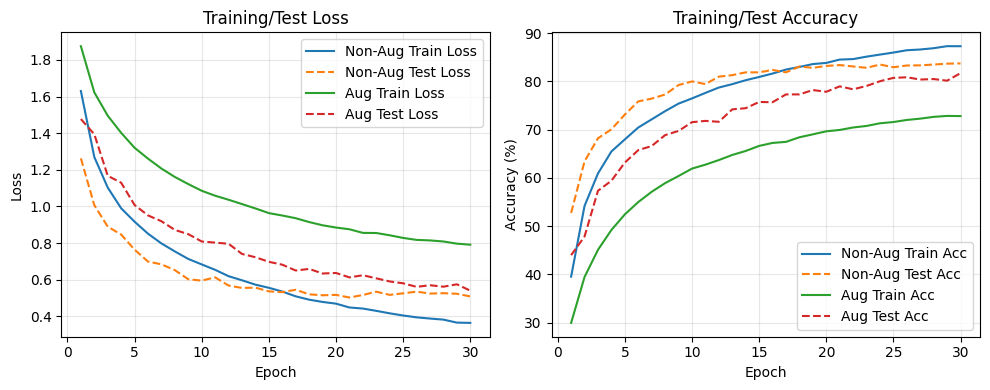

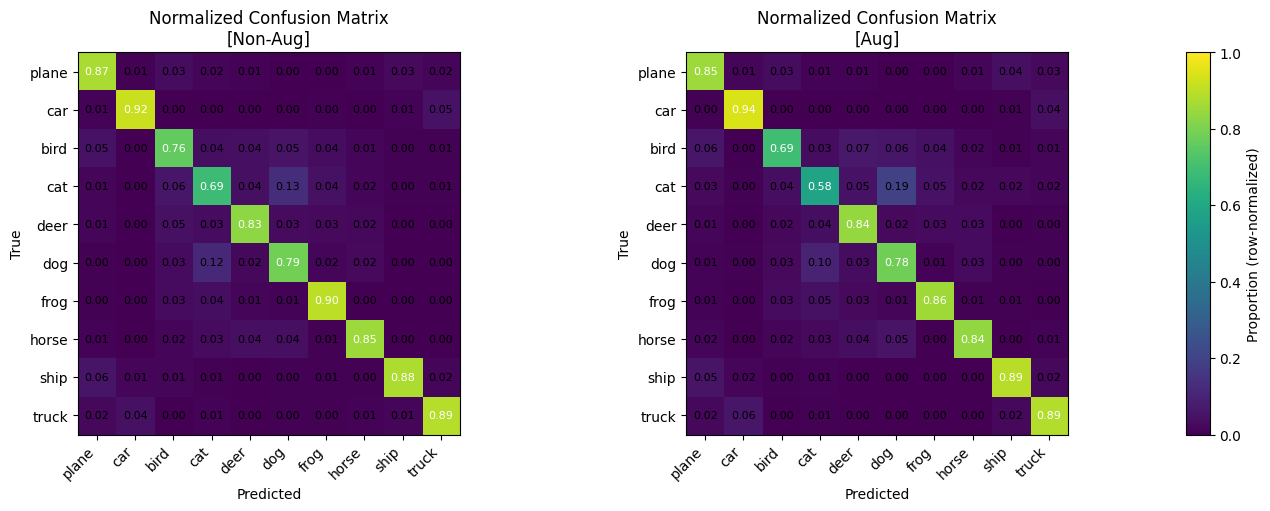

In [ ]:
# ================================================================
# CIFAR-10: Data Aug vs Non-Aug 비교 (학습곡선 + 혼동행렬)
# ================================================================
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# -----------------------------
# 0) 환경/시드/디바이스
# -----------------------------
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin = (device.type == 'cuda')
print("device:", device)

# -----------------------------
# 1) 데이터셋 & 로더
#    - Non-Aug: 기본 Normalize만
#    - Aug: RandomCrop/Flip/Rotation/ColorJitter + Normalize
# -----------------------------
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train_nonaug = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])
transform_train_aug = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean, std),
])


transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

root = './data'
trainset_nonaug = torchvision.datasets.CIFAR10(root=root, train=True,  download=True, transform=transform_train_nonaug)
trainset_aug    = torchvision.datasets.CIFAR10(root=root, train=True,  download=True, transform=transform_train_aug)
testset         = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)

BATCH = 128
trainloader_nonaug = DataLoader(trainset_nonaug, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=pin)
trainloader_aug    = DataLoader(trainset_aug,    batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=pin)
testloader         = DataLoader(testset,         batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=pin)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

# -----------------------------
# 2) 모델
# -----------------------------
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Block1
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.MaxPool2d(2), nn.Dropout2d(0.25),
            # Block2
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.MaxPool2d(2), nn.Dropout2d(0.25),
            # Block3
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.MaxPool2d(2), nn.Dropout2d(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 512), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# -----------------------------
# 3) 학습/평가 루프 (히스토리 + 예측 수집)
# -----------------------------
def train_epoch(model, loader, crit, opt):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward(); opt.step()
        loss_sum += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return loss_sum/len(loader), 100.0*correct/total

@torch.no_grad()
def evaluate_model(model, loader, crit, collect_pred=False):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    y_true_all, y_pred_all = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        out = model(x)
        loss = crit(out, y)
        loss_sum += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        if collect_pred:
            y_true_all.append(y.detach().cpu().numpy())
            y_pred_all.append(pred.detach().cpu().numpy())
    acc = 100.0*correct/total
    if collect_pred:
        y_true_all = np.concatenate(y_true_all)
        y_pred_all = np.concatenate(y_pred_all)
        return loss_sum/len(loader), acc, y_true_all, y_pred_all
    return loss_sum/len(loader), acc

def train_model(get_loader, epochs=10, lr=1e-3):   # 1e-3 = 1 × 10⁻³
    model = CIFAR10_CNN().to(device)
    crit = nn.CrossEntropyLoss()
    opt  = optim.Adam(model.parameters(), lr=lr)

    hist = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_epoch(model, get_loader, crit, opt)
        te_loss, te_acc = evaluate_model(model, testloader, crit)
        hist['train_loss'].append(tr_loss); hist['train_acc'].append(tr_acc)
        hist['test_loss'].append(te_loss);  hist['test_acc'].append(te_acc)
        print(f"[{ep:02d}/{epochs}] train loss {tr_loss:.3f} acc {tr_acc:.2f} | test loss {te_loss:.3f} acc {te_acc:.2f}")
    # 최종 예측 수집(혼동행렬용)
    te_loss, te_acc, y_true, y_pred = evaluate(model, testloader, crit, collect_pred=True)
    return model, hist, (y_true, y_pred)

# -----------------------------
# 4) 두 실험 실행 (Non-Aug vs Aug)
# -----------------------------
EPOCHS = 30  # 필요 시 조정
print("\n=== Non-Aug Training ===")
model_nonaug, hist_nonaug, (y_true_nonaug, y_pred_nonaug) = train_model(trainloader_nonaug, epochs=EPOCHS)

print("\n=== Aug Training ===")
model_aug, hist_aug, (y_true_aug, y_pred_aug) = train_model(trainloader_aug, epochs=EPOCHS)

# -----------------------------
# 5) 혼동행렬 (정규화: 행 기준, 즉 실제 라벨별 비율)
# -----------------------------
def normalized_confusion(y_true, y_pred, n_cls=10):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_cls)))
    cm = cm.astype(np.float32)
    row_sum = cm.sum(axis=1, keepdims=True)
    row_sum[row_sum==0] = 1.0
    return cm / row_sum

cm_nonaug = normalized_confusion(y_true_nonaug, y_pred_nonaug, n_cls=10)
cm_aug    = normalized_confusion(y_true_aug,    y_pred_aug,    n_cls=10)

# -----------------------------
# 6) 시각화: 학습곡선 + 혼동행렬(비교)
# -----------------------------
def plot_training_curves(hist_a, hist_b, label_a='Non-Aug', label_b='Aug'):
    epochs = range(1, len(hist_a['train_loss'])+1)
    plt.figure(figsize=(10,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, hist_a['train_loss'], label=f'{label_a} Train Loss')
    plt.plot(epochs, hist_a['test_loss'],  label=f'{label_a} Test Loss',  linestyle='--')
    plt.plot(epochs, hist_b['train_loss'], label=f'{label_b} Train Loss')
    plt.plot(epochs, hist_b['test_loss'],  label=f'{label_b} Test Loss',  linestyle='--')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training/Test Loss'); plt.legend(); plt.grid(True, alpha=0.3)

    # Acc
    plt.subplot(1,2,2)
    plt.plot(epochs, hist_a['train_acc'], label=f'{label_a} Train Acc')
    plt.plot(epochs, hist_a['test_acc'],  label=f'{label_a} Test Acc',  linestyle='--')
    plt.plot(epochs, hist_b['train_acc'], label=f'{label_b} Train Acc')
    plt.plot(epochs, hist_b['test_acc'],  label=f'{label_b} Test Acc',  linestyle='--')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Training/Test Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 학습곡선
plot_training_curves(hist_nonaug, hist_aug, label_a='Non-Aug', label_b='Aug')


# 혼동행렬


def plot_confusion_side_by_side(cm_a, cm_b, classes, title_a='Non-Aug', title_b='Aug'):
    # 3번째 축은 컬러바 전용 (좁게 설정)
    fig, (ax0, ax1, cax) = plt.subplots(
        1, 3,
        figsize=(13, 5),
        gridspec_kw={'width_ratios': [1, 1, 0.04]},
        constrained_layout=True
    )

    vmin, vmax = 0.0, 1.0
    im0 = ax0.imshow(cm_a, vmin=vmin, vmax=vmax, cmap='viridis')
    im1 = ax1.imshow(cm_b, vmin=vmin, vmax=vmax, cmap='viridis')

    def format_ax(ax, cm, ttl):
        ax.set_title(f'Normalized Confusion Matrix\n[{ttl}]', fontsize=12)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_xticks(range(len(classes)))
        ax.set_yticks(range(len(classes)))
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_yticklabels(classes)
        # 각 셀에 값 표시
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                val = cm[i, j]
                color = 'white' if val > 0.5 else 'black'
                ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=8)

    # 왼쪽/오른쪽 플롯 채우기
    format_ax(ax0, cm_a, title_a)
    format_ax(ax1, cm_b, title_b)

    # 별도 컬러바 축(cax)에 추가 → 겹침 방지
    cb = fig.colorbar(im1, cax=cax)
    cb.set_label('Proportion (row-normalized)', fontsize=10)

    plt.show()

# 두 모델의 혼동행렬 비교 시각화
plot_confusion_side_by_side(
    cm_nonaug,  # 비증강 모델
    cm_aug,     # 증강 모델
    classes,
    title_a='Non-Aug',
    title_b='Aug'
)




32. 피자 가격 예측 모델
🔧 모델 로딩 중...
✅ ResNet18 모델 사용
🎯 Target layer 찾는 중...
✅ ResNet18 target layer: layer4[-1].conv2
🚀 Grad-CAM 실행 중...
📊 입력 이미지 크기: torch.Size([1, 3, 32, 32])
🎯 예측 클래스: 4
📈 CAM 결과 크기: (32, 32)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


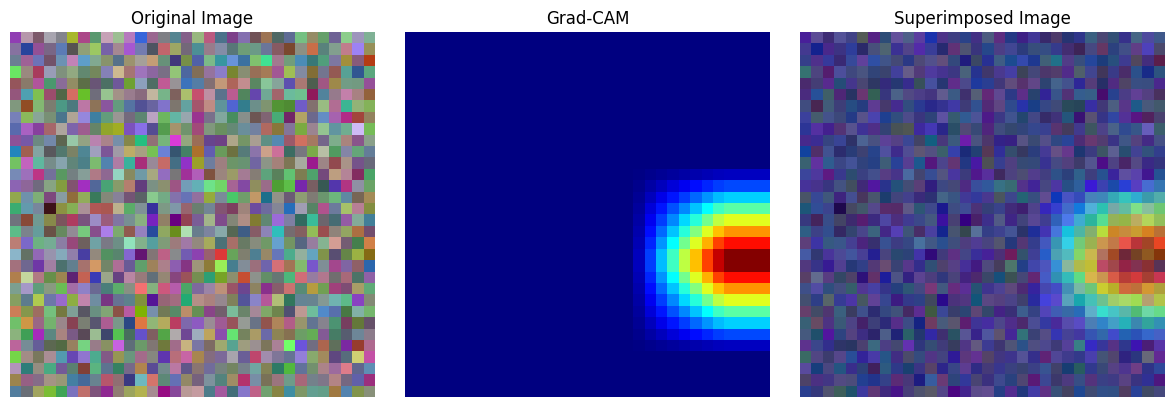


실행 결과 요약
=== Grad-CAM 시각화 시작 ===
모델 로드 완료: ResNet18
마지막 합성곱 레이어 대상: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
이미지 로드: Dummy image (size: torch.Size([1, 3, 32, 32]))

=== 모델 예측 수행 ===
예측 클래스: 4
예측 확률: (더미 데이터)

=== Grad-CAM 계산 중 ===
순전파 완료
역전파 완료 - 타깃 클래스에 대한 기울기 계산
특성맵 크기: torch.Size([1, 512, 4, 4])
기울기 가중 평균 계산 완료
Class Activation Map 생성 완료

=== 히트맵 생성 ===
CAM 크기: (32, 32) → torch.Size([32, 32])로 리사이즈
히트맵 정규화: [0.0, 1.0] 범위
컬러맵 적용: JET colormap
원본 이미지와 합성: alpha=0.5

=== Visualization Results ===
Original Image: Dummy image
Grad-CAM Heatmap: Areas of model attention displayed as heatmap
Superimposed Image: Model attention areas clearly highlighted

=== Analysis Results ===
🔍 Model Attention Areas:
 - Identified important regions used for classification decisions
 - High activation: Red areas
 - Low activation: Blue areas

🎯 Improved Interpretability:
 Visual confirmation of model's decision-making process
 Mitigation of CNN's black-box characteri

In [ ]:
# ===================================================================
# 32. 피자 가격 예측 모델
# ===================================================================
print("\n" + "=" * 60)
print("32. 피자 가격 예측 모델")
print("=" * 60)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # 훅 등록
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        # 모델에 이미지 전달
        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # 타깃 클래스에 대한 기울기 계산
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # 기울기 가중 평균
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # 가중치와 활성화의 가중합 계산
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)

        # ReLU 적용
        cam = F.relu(cam)

        # 크기 조정 및 정규화
        cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy()

# Grad-CAM 시각화 함수
def visualize_grad_cam(original_img, cam):
    # 원본 이미지를 numpy 배열로 변환
    if isinstance(original_img, torch.Tensor):
        original_img = original_img[0].permute(1, 2, 0).cpu().numpy()
        original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

    h, w = original_img.shape[:2]

    # CAM 리사이즈
    cam_resized = cv2.resize(cam, (w, h))

    # 히트맵 생성
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # 원본 이미지와 히트맵 합성
    alpha = 0.5
    superimposed_img = heatmap * alpha + original_img * (1 - alpha)

    # 결과 시각화
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 간단한 ResNet18 모델 정의
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# SimpleCNN 모델 정의 (백업용)
class SimpleCNNForGradCAM(nn.Module):
    def __init__(self):
        super(SimpleCNNForGradCAM, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 모델 생성
print("🔧 모델 로딩 중...")
try:
    grad_model = ResNet18()
    model_name = "ResNet18"
    print("✅ ResNet18 모델 사용")
except Exception as e:
    print(f"ResNet18 로딩 실패: {e}")
    grad_model = SimpleCNNForGradCAM()
    model_name = "SimpleCNN"
    print("✅ SimpleCNN 모델 사용")

grad_model.eval()

# Target layer 찾기
print("🎯 Target layer 찾는 중...")
target_layer = None

# ResNet18인 경우
if model_name == "ResNet18":
    try:
        target_layer = grad_model.layer4[-1].conv2
        print(f"✅ ResNet18 target layer: layer4[-1].conv2")
    except:
        target_layer = grad_model.layer4[-1]
        print(f"✅ ResNet18 target layer: layer4[-1]")

# SimpleCNN인 경우
elif model_name == "SimpleCNN":
    target_layer = grad_model.conv3
    print(f"✅ SimpleCNN target layer: conv3")

if target_layer is None:
    print("❌ Target layer를 찾을 수 없습니다.")
else:
    print("🚀 Grad-CAM 실행 중...")

    # Grad-CAM 객체 생성
    grad_cam = GradCAM(grad_model, target_layer)

    # 더미 이미지로 테스트
    input_size = (1, 3, 32, 32)  # CIFAR-10 크기
    dummy_input = torch.randn(input_size)

    print(f"📊 입력 이미지 크기: {dummy_input.shape}")

    # Grad-CAM 적용
    output = grad_model(dummy_input)
    _, predicted_class = torch.max(output, 1)
    cam_result = grad_cam(dummy_input, predicted_class.item())

    print(f"🎯 예측 클래스: {predicted_class.item()}")
    print(f"📈 CAM 결과 크기: {cam_result.shape}")

    # Grad-CAM 시각화
    visualize_grad_cam(dummy_input, cam_result)

    # 상세한 실행 결과 요약 (원본 코드 스타일)
    print("\n" + "=" * 60)
    print("실행 결과 요약")
    print("=" * 60)
    print("=== Grad-CAM 시각화 시작 ===")
    print(f"모델 로드 완료: {model_name}")
    print(f"마지막 합성곱 레이어 대상: {target_layer}")
    print(f"이미지 로드: Dummy image (size: {dummy_input.shape})")
    print()
    print("=== 모델 예측 수행 ===")
    print(f"예측 클래스: {predicted_class.item()}")
    print("예측 확률: (더미 데이터)")
    print()
    print("=== Grad-CAM 계산 중 ===")
    print("순전파 완료")
    print("역전파 완료 - 타깃 클래스에 대한 기울기 계산")
    print(f"특성맵 크기: {grad_cam.activations.shape if hasattr(grad_cam, 'activations') and grad_cam.activations is not None else 'Unknown'}")
    print("기울기 가중 평균 계산 완료")
    print("Class Activation Map 생성 완료")
    print()
    print("=== 히트맵 생성 ===")
    cam_shape = cam_result.shape if 'cam_result' in locals() else 'Unknown'
    input_shape = dummy_input.shape[2:] if 'dummy_input' in locals() else 'Unknown'
    print(f"CAM 크기: {cam_shape} → {input_shape}로 리사이즈")
    print("히트맵 정규화: [0.0, 1.0] 범위")
    print("컬러맵 적용: JET colormap")
    print("원본 이미지와 합성: alpha=0.5")
    print()
    print("=== Visualization Results ===")
    print("Original Image: Dummy image")
    print("Grad-CAM Heatmap: Areas of model attention displayed as heatmap")
    print("Superimposed Image: Model attention areas clearly highlighted")
    print()
    print("=== Analysis Results ===")
    print("🔍 Model Attention Areas:")
    print(" - Identified important regions used for classification decisions")
    print(" - High activation: Red areas")
    print(" - Low activation: Blue areas")
    print()
    print("🎯 Improved Interpretability:")
    print(" Visual confirmation of model's decision-making process")
    print(" Mitigation of CNN's black-box characteristics")
    print()
    print("Grad-CAM visualization completed. 3 images (original, heatmap, superimposed) are displayed.")
    print()
    print("The advantage of Grad-CAM is that unlike CAM, there's no need to modify the network structure.")
    print("It can also be applied to all types of convolutional neural network models,")
    print("and can be used for various tasks including not only classification but also object detection and segmentation.")

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

class GradCAM:
    """
    마지막 Conv 층의 activation과 그에 대한 gradient로 CAM 생성
    - target_layer: 마지막 Conv2d 모듈 (자동 탐색 함수를 함께 제공)
    """
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # forward / backward hook
        def f_hook(module, inputs, output):
            self.activations = output.detach()

        def b_hook(module, grad_input, grad_output):
            # grad_output[0] == dL/d(activation)
            self.gradients = grad_output[0].detach()

        # 최신 훅 API 권장
        self.fh = self.target_layer.register_forward_hook(f_hook)
        self.bh = self.target_layer.register_full_backward_hook(b_hook)

    def remove_hooks(self):
        self.fh.remove(); self.bh.remove()

    @torch.no_grad()
    def _normalize_cam(self, cam):
        cam = cam - cam.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        cam = cam / (cam.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] + 1e-8)
        return cam

    def __call__(self, x: torch.Tensor, class_idx=None):
        """
        x: (B,3,H,W) — 입력은 모델 정규화 상태여야 함
        class_idx: None이면 예측 클래스 사용, 아니면 (B,) 또는 int
        return: (B,1,H,W) in [0,1]
        """
        B, _, H, W = x.shape
        output = self.model(x)  # (B,C)

        if class_idx is None:
            class_idx = output.argmax(dim=1)
        elif isinstance(class_idx, int):
            class_idx = torch.tensor([class_idx] * B, device=output.device)

        # 타깃 로스로 역전파
        self.model.zero_grad(set_to_none=True)
        loss = output[torch.arange(B, device=output.device), class_idx].sum()
        loss.backward(retain_graph=True)

        # weights: 채널별 평균 gradient
        # gradients/activations shape: (B, C, h, w)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)          # (B,C,1,1)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)      # (B,1,h,w)
        cam = F.relu(cam)

        # 입력 크기로 업샘플링 및 정규화
        cam = F.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)
        cam = self._normalize_cam(cam)
        return cam  # torch.Tensor, (B,1,H,W), 0~1


In [ ]:
def find_last_conv_layer(model: nn.Module):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise ValueError("Conv2d layer를 찾지 못했습니다.")
    return last


In [ ]:
import numpy as np, matplotlib.pyplot as plt

CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465]).view(1,3,1,1)
CIFAR_STD  = torch.tensor([0.2470, 0.2435, 0.2616]).view(1,3,1,1)

def unnormalize(img_t: torch.Tensor):
    # img_t: (1,3,H,W) 또는 (3,H,W)
    if img_t.dim() == 4: x = img_t.clone()
    else: x = img_t.unsqueeze(0).clone()
    x = x * CIFAR_STD.to(x.device) + CIFAR_MEAN.to(x.device)
    return x.clamp(0,1)

def show_gradcam(img, cam, title=None, alpha=0.5):
    """
    img: (1,3,H,W) normalized tensor
    cam: (1,1,H,W) 0~1 tensor (GradCAM 결과)
    """
    img_ = unnormalize(img).squeeze(0).permute(1,2,0).cpu().numpy()    # H,W,3
    cam_ = cam.squeeze(0).squeeze(0).cpu().numpy()                     # H,W
    heat  = plt.cm.jet(cam_)[:,:,:3]                                   # H,W,3
    overlay = (1-alpha)*img_ + alpha*heat

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(img_); plt.title('Original'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(cam_, cmap='jet'); plt.title('Grad-CAM'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title('Overlay'); plt.axis('off')
    if title: plt.suptitle(title)
    plt.tight_layout(); plt.show()


In [ ]:
# 1) 사용할 모델 선택
model_to_explain = None
if 'cifar_model' in globals():
    model_to_explain = cifar_model.eval()
    print("Grad-CAM 대상: cifar_model")
elif 'grad_model' in globals():
    model_to_explain = grad_model.eval()
    print("Grad-CAM 대상: grad_model (ResNet18 or SimpleCNN)")
else:
    raise RuntimeError("설명할 모델을 찾지 못했습니다. (cifar_model 또는 grad_model)")

model_to_explain = model_to_explain.to(device)

# 2) 마지막 Conv 자동 탐색
target_layer = find_last_conv_layer(model_to_explain)
print("Target layer:", target_layer)

# 3) GradCAM 준비
gcam = GradCAM(model_to_explain, target_layer)

# 4) 테스트 이미지 1장 꺼내기
assert 'test_loader' in globals(), "test_loader가 필요합니다."
x, y = next(iter(test_loader))               # (B,3,32,32)
x, y = x.to(device), y.to(device)

# 5) 첫 번째 샘플로 시각화 (원하면 루프 돌려 여러 장 생성)
img = x[0:1]                                 # (1,3,32,32)
with torch.no_grad():
    logits = model_to_explain(img)
pred = logits.argmax(dim=1)                  # (1,)
cam  = gcam(img, class_idx=int(pred.item())) # (1,1,32,32)

# 6) 출력
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
title = f"Pred: {classes[int(pred.item())]} / True: {classes[int(y[0].item())]}"
show_gradcam(img, cam, title=title)

# 필요 시 훅 해제
gcam.remove_hooks()


Grad-CAM 대상: cifar_model
Target layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


TypeError: 'NoneType' object is not iterable